# Preprocessing

In [1]:
import sys
sys.path.append('/mnt/5e85af0b-fa6b-4dca-a539-449bff7060b4/Courses/NLP/arabic-sentiment-analysis-master/')

In [2]:
import matplotlib.pyplot as plt
import farasa
import farasa.stemmer as st
import re
import elements
import string
import emoji
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/amr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))

In [4]:
test = '   أحتاج أن أري   الكًَثـــير من الأشيــــاء    @و , '

In [5]:
def tashkel_removal(t):
    return t.translate(t.maketrans('',"",''.join(elements.DIACRITICS)))

In [6]:
def tatweel_removal(t):
    return re.sub('ـ+', '',t)

In [7]:
def normalization(t):
    return t.translate(t.maketrans(''.join(elements.ALEF_HAMZA_FORMS+elements.NON_ALIF_HAMZA_FORMS),"اااوي"))

In [8]:
def stopwords_removal(t,stop=arb_stopwords):
    return ' '.join([word for word in t.split() if word not in stop])
    

In [9]:
def successive_space_removal(t):
    t=t.strip()
    return re.sub(' +', ' ',t)

In [10]:
def punctuation_removal(t):
    return t.translate(t.maketrans('',"",''.join(elements.PUNCTUATION_MARKS[:-1])+'?'))

In [11]:
def emojify(t):
    return emoji.demojize(t)

### Stemmers

In [12]:
def stemmer(t, stemming_function):
    return stemming_function(t)

##### Farasa

In [13]:
import farasa.segmenter as sg

In [14]:
farasa_st = farasa.stemmer.FarasaStemmer()

##### Tachafyne

In [15]:
import pyarabic.arabrepr
arepr = pyarabic.arabrepr.ArabicRepr()
repr = arepr.repr
from tashaphyne.stemming import ArabicLightStemmer

In [16]:
tach_st = ArabicLightStemmer()

In [17]:
tach_st.light_stem(test)

'   أحتاج أن أري   الكثـــير من الأشيــــاء    @و , '

##### ASSEM

In [18]:
from snowballstemmer import stemmer

In [19]:
assem_st = stemmer("arabic")

In [20]:
assem_st.stemWord(test)

'   احتاج ان اري   الكثير من الاشياء    @و , '

##### NLTK

In [21]:
from nltk.stem.isri import ISRIStemmer

In [22]:
nltk_st = ISRIStemmer()

In [23]:
nltk_st.stem(test)

'   أحتاج أن أري   الكثـــير من الأشيــــاء    @و , '

##### فاصل

In [24]:
prep = [stopwords_removal,tashkel_removal,tatweel_removal,punctuation_removal,
        normalization,emojify,successive_space_removal]

In [25]:
def process(text,prep=prep):
    for i in prep:
        text=i(text)
    return text

## Data 

In [26]:
import numpy as np
import pandas as pd
import os
import time

In [34]:
path = '../arabic-sentiment-analysis-master/arabic_tweets_txt/'

In [35]:
files = os.listdir(path)

In [36]:
def read(i,files):
    return pd.read_csv(f'{path}/{files[i]}',sep='\t',names=['tweet'])

In [37]:
#Data is already separated based on label
train_pos,train_neg , val_pos,val_neg= pd.concat([read(1,files),read(2,files)]).values,read(4,files).values,read(3,files).values,read(6,files).values

### Stemmer Analysis

In [56]:
temp = pd.DataFrame(train_pos,columns=['text']).text

In [38]:
stemmers = [farasa_st.stem,tach_st.light_stem,assem_st.stemWord,nltk_st.stem]

In [58]:
t_e=[]
for i in range(len(stemmers)):
    s=time.time()
    temp[:5].apply(stemmers[i])
    e=time.time()
    t_e.append(e-s)

<BarContainer object of 4 artists>

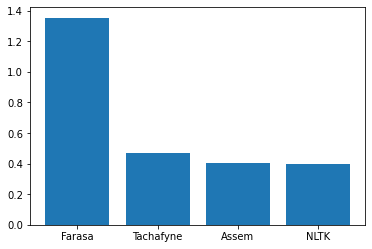

In [59]:
plt.bar(['Farasa','Tachafyne','Assem','NLTK'],np.power(t_e,1/8))

We will proceed with Assem Segmenter

## Data set ratio

In [30]:
total= len(train_pos)+len(train_neg)

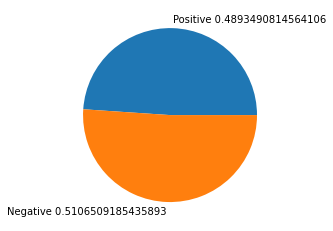

In [31]:
plt.pie([len(train_pos),len(train_neg)],labels=[f'Positive {len(train_pos)/total}',f'Negative {len(train_neg)/total}']);

### Vector Representation
Each word is represented in vector if size 3. [1 for bias, word freq in positive dataset, word_freq in negative dataset ] <br> We will compare between multiple arabic stemmers: 1- Farasa 2- Asem 3- Tashaphyne 4-NLTK In terms of speed and final result using both bayes rule and vector space.

In [60]:
import collections
import random

In [61]:
train_pos = pd.DataFrame(train_pos,columns=['text']).text.apply(process).apply(nltk_st.stem)
train_neg = pd.DataFrame(train_neg,columns=['text']).text.apply(process).apply(nltk_st.stem)

In [62]:
#Prepare test datasets
test_pos = pd.DataFrame(val_pos,columns=['text']).text.apply(process).apply(nltk_st.stem)
test_neg = pd.DataFrame(val_neg,columns=['text']).text.apply(process).apply(nltk_st.stem)

In [63]:
raw_pos = ' '.join(train_pos.values)
raw_neg = ' '.join(train_neg.values)

In [64]:
freq_pos = collections.Counter(raw_pos.split())
freq_neg = collections.Counter(raw_neg.split())

In [65]:
all_words = list(set(list(freq_pos.keys())+list(freq_neg.keys())))

In [ ]:
a = dict()
for i in all_words:
    a[i] = abs(freq_pos.get(i,0)-freq_neg.get(i,0))

In [69]:
b = dict(sorted(a.items(), key=lambda item: item[1],reverse=True))

In [87]:
pos_v=[]
neg_v=[]
word=[]
for i in range(10):
    n = random.randint(0,len(all_words))
    #word.append(all_words[n])
    word.append(list(b.keys())[i])
    pos_v.append(freq_pos.get(word[-1],1))
    neg_v.append(freq_neg.get(word[-1],1))

In [88]:
v = np.array(pos_v) / np.array(neg_v)

In [89]:
v = ['red' if i>1 else 'black' for i in v]

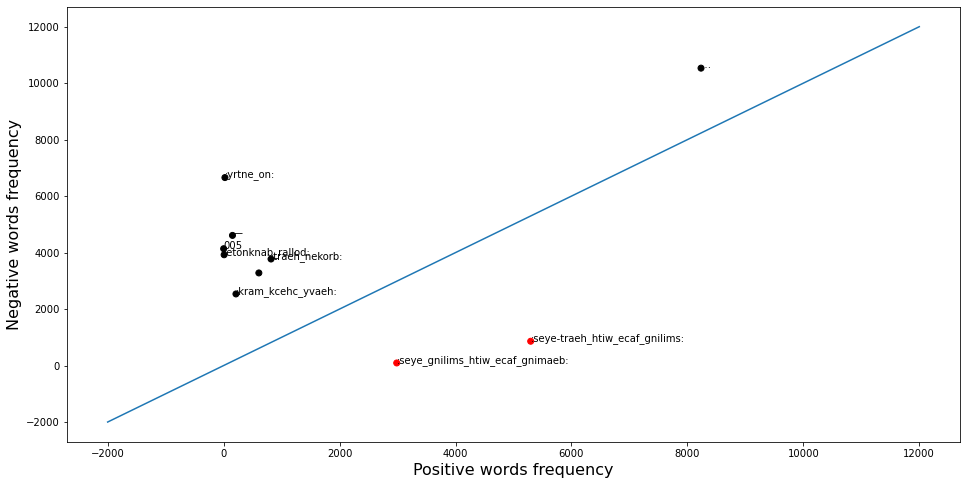

In [90]:
fig,ax= plt.subplots(figsize=(16,8))
plt.xlabel('Positive words frequency', fontsize=16)
plt.ylabel('Negative words frequency', fontsize=16)
ax.scatter(pos_v,neg_v,c=v)
min_limit , max_limit = min(plt.xticks()[0][0],plt.yticks()[0][0]),max(plt.xticks()[0][-1],plt.yticks()[0][-1])
ax.plot([min_limit , max_limit],[min_limit , max_limit])
for i, txt in enumerate(word):
    ax.annotate(txt[::-1], (pos_v[i], neg_v[i]))

### Dataset Preparation

In [350]:
def prepare_dataset(pos_ds,neg_ds,pos_label=1,neg_label=0):
    x = pd.DataFrame(pos_ds)
    x['label']=pos_label
    y = pd.DataFrame(neg_ds)
    y['label']=neg_label
    X = np.concatenate([x.values,y.values])
    #np.random.shuffle(X)
    return X[:,0],X[:,1]

In [351]:
X_train,Y_train = prepare_dataset(train_pos,train_neg)
X_val,Y_val = prepare_dataset(val_pos,val_neg)

## Vector Represenation

In [ ]:
def doc_rep(text,pos_freq,neg_freq):
    vec = np.ones(3)
    vec[0] = 0.5
    for i in text.split():
        vec[1] += pos_freq.get(i,1)
        vec[2] += neg_freq.get(i,1)
    return vec

In [ ]:
doc_rep(X_train[200],freq_pos,freq_neg)

In [ ]:
X = np.zeros((len(X_train),3))
for i in range(len(X_train)):
    X[i,:] = doc_rep(X_train[i],freq_pos,freq_neg)

In [ ]:
Val = np.zeros((len(X_val),3))
for i in range(len(X_val)):
    Val[i,:] = doc_rep(X_val[i],freq_pos,freq_neg)

## Logistic Regression

In [ ]:
import sklearn

In [ ]:
lr_model = sklearn.linear_model.LogisticRegression()

In [ ]:
lr_model.fit(np.log(X),Y_train.astype('int'))

In [ ]:
lr_model.score(X,Y_train.astype('int'))

In [ ]:
lr_model.score(Val,Y_val.astype('int'))

In [ ]:
lr_model.coef_

## Naive Bayes

In [344]:
def naive_bayes(X,Y,freq_pos,freq_neg,all_words):
    
    D = len(Y)
    D_pos = len(Y[Y==1])
    D_neg = D-D_pos
    
    log_prior = np.log(D_pos/D) - np.log(D_neg/D)
    
    V = len(all_words)
    N_pos = sum(freq_pos.values())
    N_neg = sum(freq_neg.values())
    
    log = dict()
    for c,word in enumerate(all_words):
        word_pos = (freq_pos.get(word,0) + 1) / (V+N_pos)
        
        word_neg = (freq_neg.get(word,0) + 1) / (V+N_neg)
        
        log[word] = np.log(word_pos)-np.log(word_neg)
    return log_prior,log

In [353]:
prior,log = naive_bayes(X_train,Y_train,freq_pos,freq_neg,all_words)

In [368]:
def nb_tweet(text,log_dict,prior):
    res = prior
    for word in text.split():
        res += log_dict.get(word,0)
    return res > 0

In [369]:
def nb_ds(X,log_dict,prior):
    y_hat = []
    for doc in X:
        y_hat.append(nb_tweet(doc,log_dict,prior))
    return np.array(y_hat)

In [370]:
y_hat = nb_ds(X_train,log,prior)

In [373]:
(Y_train == y_hat).sum() / len(Y_train)

0.9480102583785481

In [375]:
y_hat = nb_ds(X_val,log,prior)

In [376]:
(Y_val == y_hat).sum() / len(Y_val)

0.6298534521831093